In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime
import math
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error

from pylab import rcParams
from tqdm import tqdm_notebook
import fbprophet

In [2]:
df_merged_no_hol = pd.read_csv('usage_and_failed_search_no_hol.csv')

In [3]:
df_o = df_merged_no_hol[df_merged_no_hol['Station_depart.'] == '12 CU Terrace']
df_od = df_o[df_o['Station_dest.'] == '04 Engineering']

df_od.head(14)

start = 7
stop = 8.5
hours = stop-start
days_forecast = 6
hours_multiplier = 2

In [4]:
df_od['DateTime'] = df_od[df_od.columns[0:2]].apply(lambda x : '/' .join(x.astype(str)),axis=1)
df_od['DateTime'] = df_od['DateTime'].str.replace(":", "/")

demand = []
demand = [1] * len(df_od)
df_od['Demand'] = demand
df_od

,Date,regist_dt_ICT,start_dt_ICT,end_dt_ICT,Customer_ID,Station_depart.,Station_dest.,DateTime,Demand
87,7/1/2019,08:44:00,09:02:11,09:08:28,CP#0PFV4,12 CU Terrace,04 Engineering,7/1/2019/08/44/00,1
88,7/1/2019,08:50:49,08:51:18,08:58:37,CP#0PVP6,12 CU Terrace,04 Engineering,7/1/2019/08/50/49,1
97,7/1/2019,11:05:15,11:06:27,11:11:10,CP#0PGZ3,12 CU Terrace,04 Engineering,7/1/2019/11/05/15,1
110,7/1/2019,12:37:46,12:39:18,12:44:42,CP#0PVP6,12 CU Terrace,04 Engineering,7/1/2019/12/37/46,1
122,7/1/2019,13:39:56,13:40:42,13:45:58,CP#0S822,12 CU Terrace,04 Engineering,7/1/2019/13/39/56,1
...,...,...,...,...,...,...,...,...,...
19890,27/9/2019,16:16:45,16:22:32,16:27:29,CP#0SF89,12 CU Terrace,04 Engineering,27/9/2019/16/16/45,1
19948,30/9/2019,07:59:18,NaN,NaN,CP#0SZM7,12 CU Terrace,04 Engineering,30/9/2019/07/59/18,1
19951,30/9/2019,08:32:13,08:32:46,08:38:59,CP#0V2Y4,12 CU Terrace,04 Engineering,30/9/2019/08/32/13,1
19953,30/9/2019,08:44:38,NaN,NaN,CP#0SLD2,12 CU Terrace,04 Engineering,30/9/2019/08/44/38,1


In [5]:
df_od['Date'] = pd.to_datetime(df_od['Date'], dayfirst=True)
df_od.set_index('Date', inplace=True)
df_train = df_train_clone = df_od[:'2019-04-30']
df_test = df_test_clone = df_od['2019-05-01':'2019-05-23']
df_train2 = df_train_clone2 = df_od['2019-08-13':'2019-09-20']
df_test2 = df_test_clone2 = df_od['2019-09-23':'2019-09-30']
# df_cv = df_cv_clone = df_od[:'2019-05-23']
df_train_clone = df_train_clone.reset_index()
df_test_clone = df_test_clone.reset_index()
df_train_clone2 = df_train_clone2.reset_index()
df_test_clone2 = df_test_clone2.reset_index()
# df_cv_clone = df_cv_clone.reset_index()
df_train_clone

,Date,regist_dt_ICT,start_dt_ICT,end_dt_ICT,Customer_ID,Station_depart.,Station_dest.,DateTime,Demand
0,2019-01-07,08:44:00,09:02:11,09:08:28,CP#0PFV4,12 CU Terrace,04 Engineering,7/1/2019/08/44/00,1
1,2019-01-07,08:50:49,08:51:18,08:58:37,CP#0PVP6,12 CU Terrace,04 Engineering,7/1/2019/08/50/49,1
2,2019-01-07,11:05:15,11:06:27,11:11:10,CP#0PGZ3,12 CU Terrace,04 Engineering,7/1/2019/11/05/15,1
3,2019-01-07,12:37:46,12:39:18,12:44:42,CP#0PVP6,12 CU Terrace,04 Engineering,7/1/2019/12/37/46,1
4,2019-01-07,13:39:56,13:40:42,13:45:58,CP#0S822,12 CU Terrace,04 Engineering,7/1/2019/13/39/56,1
...,...,...,...,...,...,...,...,...,...
273,2019-04-30,10:41:42,10:49:13,10:56:17,CP#0S6F7,12 CU Terrace,04 Engineering,30/4/2019/10/41/42,1
274,2019-04-30,12:10:07,NaN,NaN,CP#0S6F7,12 CU Terrace,04 Engineering,30/4/2019/12/10/07,1
275,2019-04-30,12:26:27,12:28:37,12:34:53,CP#0V2Y4,12 CU Terrace,04 Engineering,30/4/2019/12/26/27,1
276,2019-04-30,12:37:56,NaN,NaN,CP#0V5Q7,12 CU Terrace,04 Engineering,30/4/2019/12/37/56,1


In [6]:
df_od = df_od.reset_index()
df_od

,Date,regist_dt_ICT,start_dt_ICT,end_dt_ICT,Customer_ID,Station_depart.,Station_dest.,DateTime,Demand
0,2019-01-07,08:44:00,09:02:11,09:08:28,CP#0PFV4,12 CU Terrace,04 Engineering,7/1/2019/08/44/00,1
1,2019-01-07,08:50:49,08:51:18,08:58:37,CP#0PVP6,12 CU Terrace,04 Engineering,7/1/2019/08/50/49,1
2,2019-01-07,11:05:15,11:06:27,11:11:10,CP#0PGZ3,12 CU Terrace,04 Engineering,7/1/2019/11/05/15,1
3,2019-01-07,12:37:46,12:39:18,12:44:42,CP#0PVP6,12 CU Terrace,04 Engineering,7/1/2019/12/37/46,1
4,2019-01-07,13:39:56,13:40:42,13:45:58,CP#0S822,12 CU Terrace,04 Engineering,7/1/2019/13/39/56,1
...,...,...,...,...,...,...,...,...,...
614,2019-09-27,16:16:45,16:22:32,16:27:29,CP#0SF89,12 CU Terrace,04 Engineering,27/9/2019/16/16/45,1
615,2019-09-30,07:59:18,NaN,NaN,CP#0SZM7,12 CU Terrace,04 Engineering,30/9/2019/07/59/18,1
616,2019-09-30,08:32:13,08:32:46,08:38:59,CP#0V2Y4,12 CU Terrace,04 Engineering,30/9/2019/08/32/13,1
617,2019-09-30,08:44:38,NaN,NaN,CP#0SLD2,12 CU Terrace,04 Engineering,30/9/2019/08/44/38,1


In [7]:
def fill_missing(df, df_main, type):
    date = list(dict.fromkeys(df_main['Date']))
    if (type == True):
        oper_time = list(np.arange(start, stop, 0.5))
    else:
        oper_time = list(np.arange(start, stop))
    timestamp_all = []

    for each in date:
        each = str(each)
        each = each[0:11]
        for h in oper_time:
            (y, m, d) = each.split('-')
            d = int(d)
            m = int(m)
            y = int(y)
            hh = int(h)
            if (((h*10)%10) == 5):
                timestamp = pd.Timestamp(year=y, month=m, day=d, hour=hh, minute=30)
            else:
                timestamp = pd.Timestamp(year=y, month=m, day=d, hour=hh, minute = 30)
            timestamp_all.append(timestamp)

    timestamp_fill = list(set(timestamp_all) - set((list(dict.fromkeys(df_main['Timestamp'])))))
    
    demand_fill = []
    demand_fill = [0] * len(timestamp_fill)

    data_fill = {'Timestamp': timestamp_fill, 'Demand': demand_fill}    
    df_od_fill = pd.DataFrame(data_fill)
    df_od_fill = df_od_fill.sort_values('Timestamp')
    df_od_fill = df_od_fill.reset_index(drop=True)
    
    df, backup = group_by_time(df)
    
    df = df.append(df_od_fill)
    df = df.sort_values('Timestamp')
    
    return df

def group_by_time(df):
    df = df.groupby('Timestamp').sum()
    backup = df
    df = df.reset_index()
    
    return df, backup

def create_window(df):
    converted_regist = []

    for slot in df['regist_dt_ICT']:
        (h, m, s) = slot.split(':')
        time_float = int(h) + int(m)/60 + int(s)/3600
        converted_regist.append(math.floor(time_float))    

    df['Converted_Regist'] = converted_regist

    df = df[df['Converted_Regist'] >= start]
    df = df[df['Converted_Regist'] < stop]
    df = df.drop(['Converted_Regist'], axis=1)
    
    return df

def create_timestamp(df, type): 
    timestamp_converted = []
    for slot in df['DateTime']:
        (d, m, y, hh, mm, ss) = slot.split('/')
        d = int(d)
        m = int(m)
        y = int(y)
        hh = int(hh)
        mm = int(mm)
        if (type == True):
            if (mm >= 31):
                timestamp = pd.Timestamp(year=y, month=m, day=d, hour=hh, minute = 30)
            else:
                timestamp = pd.Timestamp(year=y, month=m, day=d, hour=hh)
        else:
            timestamp = pd.Timestamp(year=y, month=m, day=d, hour=hh, minute = 30)
        timestamp_converted.append(timestamp)
    df['Timestamp'] = timestamp_converted
    
    return df

In [8]:
df_train_clone = create_timestamp(df_train_clone, True)
train_framed = create_window(df_train_clone)
train, backup_train = group_by_time(train_framed)
train = fill_missing(train, df_train_clone, True)
train

,Timestamp,Demand
0,2019-01-07 07:30:00,0
0,2019-01-07 08:30:00,2
1,2019-01-08 07:30:00,0
1,2019-01-08 08:30:00,2
2,2019-01-10 07:30:00,0
...,...,...
79,2019-04-26 08:30:00,1
88,2019-04-29 07:30:00,0
89,2019-04-29 08:30:00,0
90,2019-04-30 07:30:00,0


In [9]:
df_test_clone = create_timestamp(df_test_clone, False)
test_framed = create_window(df_test_clone)
test, backup_test = group_by_time(test_framed)
test = fill_missing(test, df_test_clone, False)
test

,Timestamp,Demand
0,2019-05-01 07:30:00,0
0,2019-05-01 08:30:00,2
1,2019-05-02 07:30:00,0
1,2019-05-02 08:30:00,2
2,2019-05-03 07:30:00,0
3,2019-05-03 08:30:00,0
2,2019-05-07 07:30:00,1
3,2019-05-07 08:30:00,1
4,2019-05-08 07:30:00,2
5,2019-05-08 08:30:00,2


In [10]:
df_train_clone2 = create_timestamp(df_train_clone2, True)
train_framed2 = create_window(df_train_clone2)
train2, backup_train2 = group_by_time(train_framed2)
train2 = fill_missing(train2, df_train_clone2, True)
train2

,Timestamp,Demand
0,2019-08-13 07:30:00,1
0,2019-08-13 08:30:00,0
1,2019-08-14 07:30:00,1
2,2019-08-14 08:30:00,1
1,2019-08-15 07:30:00,0
...,...,...
26,2019-09-18 08:30:00,0
27,2019-09-19 07:30:00,0
37,2019-09-19 08:30:00,1
28,2019-09-20 07:30:00,0


In [11]:
df_test_clone2 = create_timestamp(df_test_clone2, False)
test_framed2= create_window(df_test_clone2)
test2, backup_test2 = group_by_time(test_framed2)
test2 = fill_missing(test2, df_test_clone2, False)
test2

,Timestamp,Demand
0,2019-09-23 07:30:00,1
1,2019-09-23 08:30:00,1
2,2019-09-24 07:30:00,1
0,2019-09-24 08:30:00,0
1,2019-09-25 07:30:00,0
3,2019-09-25 08:30:00,4
2,2019-09-26 07:30:00,0
3,2019-09-26 08:30:00,0
4,2019-09-27 07:30:00,0
5,2019-09-27 08:30:00,0


In [12]:
# cv, backup_cv = group_by_time(df_cv)
# cv = fill_missing(cv, df_cv_clone)
# cv

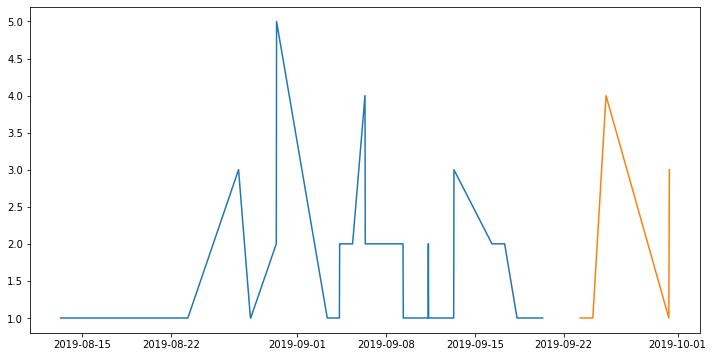

In [13]:
plt.figure(figsize=(12,6))
plt.plot(backup_train2)
plt.plot(backup_test2)

In [14]:
df_prophet = train2[['Timestamp', 'Demand']]
df_prophet = df_prophet.rename(columns={'Timestamp': 'ds', 'Demand': 'y'})
df_prophet

,ds,y
0,2019-08-13 07:30:00,1
0,2019-08-13 08:30:00,0
1,2019-08-14 07:30:00,1
2,2019-08-14 08:30:00,1
1,2019-08-15 07:30:00,0
...,...,...
26,2019-09-18 08:30:00,0
27,2019-09-19 07:30:00,0
37,2019-09-19 08:30:00,1
28,2019-09-20 07:30:00,0


In [15]:
# df_prophet = cv[['Timestamp', 'Demand']]
# df_prophet = df_prophet.rename(columns={'Timestamp': 'ds', 'Demand': 'y'})
# df_prophet

In [16]:
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)
# df_prophet['cap'] = 10
# df_prophet['floor'] = 0
# m = Prophet(growth='logistic', changepoint_prior_scale=0.1)
m = Prophet(changepoint_prior_scale=0.1)
m.fit(df_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [17]:
future = m.make_future_dataframe(periods=600, freq='H')
# future['cap'] = 10
# future['floor'] = 0
future = future[(future['ds'].dt.hour >= start) & (future['ds'].dt.hour < stop)]
future = future[future['ds'].dt.dayofweek < 5]
forecast = m.predict(future)
yhat_round = []
for each in forecast['yhat']:
    if (each < 0):
        each = 0
#     elif (each >= 1 and each <= 1.3):
#         each = 1
    elif (((each*10)%10) > 5):
        each = math.ceil(each)
    else:
        each = math.floor(each)
    yhat_round.append(each)
# forecast['yhat_round'] = yhat_round
# forecast[['ds', 'yhat_round', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast['yhat_nr'] = forecast['yhat']
forecast['yhat'] = yhat_round
forecast[['ds', 'yhat', 'yhat_nr', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_nr,yhat_lower,yhat_upper
0,2019-08-13 07:30:00,0,0.383610,-0.594623,1.453507
1,2019-08-13 08:30:00,1,1.154503,0.089657,2.134298
2,2019-08-14 07:30:00,0,0.252991,-0.817736,1.298469
3,2019-08-14 08:30:00,1,1.047101,-0.078151,2.089276
4,2019-08-15 07:30:00,0,-0.080055,-1.158320,0.991865
...,...,...,...,...,...
97,2019-10-11 08:30:00,2,2.063764,1.011679,3.140242
98,2019-10-14 07:30:00,1,0.655104,-0.409982,1.649820
99,2019-10-14 08:30:00,1,1.037567,-0.059367,2.054412
100,2019-10-15 07:30:00,1,0.717238,-0.354363,1.763507


In [18]:
forecast.tail(len(df_prophet))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,yhat_nr
34,2019-09-04 07:30:00,1.357459,-0.688923,1.362896,1.357459,1.357459,-0.991696,-0.991696,-0.991696,6.676241,6.676241,6.676241,-7.667937,-7.667937,-7.667937,0.0,0.0,0.0,0,0.365763
35,2019-09-04 08:00:00,1.357570,0.655910,2.775982,1.357570,1.357570,0.373811,0.373811,0.373811,8.011714,8.011714,8.011714,-7.637903,-7.637903,-7.637903,0.0,0.0,0.0,2,1.731381
36,2019-09-04 08:30:00,1.357680,0.150620,2.264808,1.357680,1.357680,-0.197809,-0.197809,-0.197809,7.408203,7.408203,7.408203,-7.606012,-7.606012,-7.606012,0.0,0.0,0.0,1,1.159871
37,2019-09-05 07:30:00,1.362743,-1.076239,1.121404,1.362743,1.362743,-1.330119,-1.330119,-1.330119,6.676241,6.676241,6.676241,-8.006360,-8.006360,-8.006360,0.0,0.0,0.0,0,0.032624
38,2019-09-05 08:30:00,1.362963,-0.486417,1.630803,1.362963,1.362963,-0.815557,-0.815557,-0.815557,7.408203,7.408203,7.408203,-8.223760,-8.223760,-8.223760,0.0,0.0,0.0,1,0.547406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2019-10-11 08:30:00,1.552138,1.011679,3.140242,1.551732,1.552520,0.511626,0.511626,0.511626,7.408203,7.408203,7.408203,-6.896577,-6.896577,-6.896577,0.0,0.0,0.0,2,2.063764
98,2019-10-14 07:30:00,1.567683,-0.409982,1.649820,1.567175,1.568147,-0.912579,-0.912579,-0.912579,6.676241,6.676241,6.676241,-7.588820,-7.588820,-7.588820,0.0,0.0,0.0,1,0.655104
99,2019-10-14 08:30:00,1.567902,-0.059367,2.054412,1.567393,1.568367,-0.530335,-0.530335,-0.530335,7.408203,7.408203,7.408203,-7.938538,-7.938538,-7.938538,0.0,0.0,0.0,1,1.037567
100,2019-10-15 07:30:00,1.572938,-0.354363,1.763507,1.572402,1.573431,-0.855700,-0.855700,-0.855700,6.676241,6.676241,6.676241,-7.531941,-7.531941,-7.531941,0.0,0.0,0.0,1,0.717238


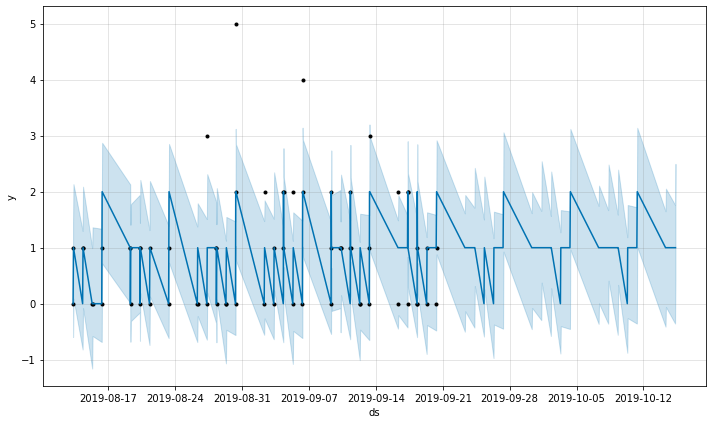

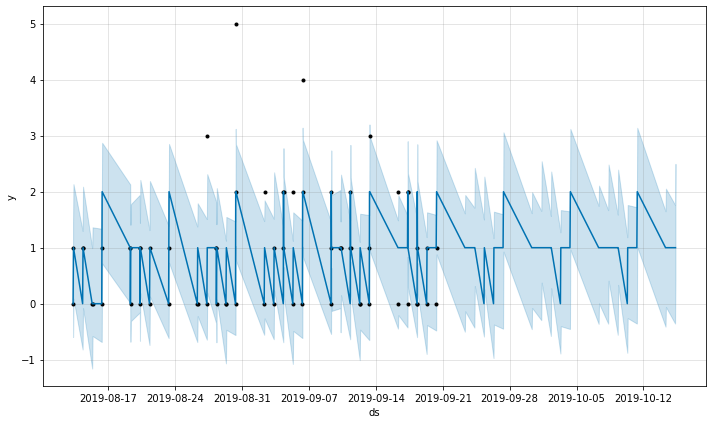

In [19]:
m.plot(forecast)

In [20]:
def join_eva(train, forecast, prediction_size):
    forecast = forecast[:prediction_size]
    return forecast.set_index('ds')[['yhat', 'yhat_nr', 'yhat_lower', 'yhat_upper']].join(train.set_index('ds'))

def cal_SMAPE(df):
    smape = 100/len(df) * np.sum(2 * np.abs(df['yhat'] - df['y']) / (np.abs(df['y']) + np.abs(df['yhat'])))
    print(df)
    return 'sMAPE', smape, 'accuracy', 100-smape

train = join_eva(df_prophet, forecast, len(df_prophet))

print(cal_SMAPE(train))

                     yhat   yhat_nr  yhat_lower  yhat_upper  y
ds                                                            
2019-08-13 07:30:00     0  0.383610   -0.594623    1.453507  1
2019-08-13 08:30:00     1  1.154503    0.089657    2.134298  0
2019-08-14 07:30:00     0  0.252991   -0.817736    1.298469  1
2019-08-14 08:30:00     1  1.047101   -0.078151    2.089276  1
2019-08-15 07:30:00     0 -0.080055   -1.158320    0.991865  0
...                   ...       ...         ...         ... ..
2019-09-18 08:30:00     1  1.233474    0.199722    2.183745  0
2019-09-19 07:30:00     0  0.106200   -0.898405    1.188477  0
2019-09-19 08:30:00     1  0.620980   -0.382335    1.631421  1
2019-09-20 07:30:00     1  0.516954   -0.479073    1.585821  0
2019-09-20 08:30:00     2  1.953418    0.880943    2.917894  1

[68 rows x 5 columns]
('sMAPE', 71.94677871148458, 'accuracy', 28.053221288515417)


In [21]:
def join_test(test, forecast, prediction_size):
    df_test = test.rename(columns={'Timestamp': 'ds', 'Demand': 'y'})
    forecast = forecast[len(df_prophet):len(df_prophet)+prediction_size]
    return forecast.set_index('ds')[['yhat', 'yhat_nr', 'yhat_lower', 'yhat_upper']].join(df_test.set_index('ds'))

eva_df = join_test(test2, forecast, days_forecast*hours_multiplier)

print(cal_SMAPE(eva_df))

                     yhat   yhat_nr  yhat_lower  yhat_upper  y
ds                                                            
2019-09-23 07:30:00     1  0.544758   -0.500088    1.612212  1
2019-09-23 08:30:00     1  0.927221   -0.136037    1.940804  1
2019-09-24 07:30:00     1  0.606892   -0.427155    1.712413  1
2019-09-24 08:30:00     1  1.377780    0.316547    2.424683  0
2019-09-25 07:30:00     0  0.476150   -0.587052    1.503000  0
2019-09-25 08:30:00     1  1.270256    0.257124    2.269287  4
2019-09-26 07:30:00     0  0.142982   -0.971175    1.168228  0
2019-09-26 08:30:00     1  0.657763   -0.372467    1.642550  0
2019-09-27 07:30:00     1  0.553736   -0.446637    1.596418  0
2019-09-27 08:30:00     2  1.990200    0.929492    3.059243  0
2019-09-30 07:30:00     1  0.581540   -0.454685    1.615878  1
2019-09-30 08:30:00     1  0.964003   -0.076331    1.990523  3
('sMAPE', 85.0, 'accuracy', 15.0)


In [ ]:
eva_df.head(30)

In [ ]:
scales = np.arange(0.1,1.0,0.1)

def grid_search():
    scale = [] 
    eva_acc = []
    test_acc = []
    for param in scales:
        scale.append(param)
        m = Prophet(changepoint_prior_scale=param) 
        m.fit(df_prophet)
        future = m.make_future_dataframe(periods=600, freq='H')
        future = future[(future['ds'].dt.hour >= start) & (future['ds'].dt.hour < stop)]
        future = future[future['ds'].dt.dayofweek < 5]
        forecast = m.predict(future)
        yhat_round = []
        for each in forecast['yhat']:
            if (each < 0):
                each = 0
            elif (((each*10)%10) > 5):
                each = math.ceil(each)
            else:
                each = math.floor(each)
            yhat_round.append(each)
        forecast['yhat_nr'] = forecast['yhat']
        forecast['yhat'] = yhat_round

        train = join_eva(df_prophet, forecast, len(df_prophet))
        acc = cal_SMAPE(train)
        eva_acc.append(acc)

        eva_df = join_test(test2, forecast, days_forecast*hours_multiplier)
        acc = cal_SMAPE(eva_df)
        test_acc.append(acc)
    
    return scale, eva_acc, test_acc

scale, eva_acc, test_acc = grid_search()
grid = {'Scale': scale, 'Fit': eva_acc, 'Test': test_acc}    
df_grid = pd.DataFrame(grid)
df_grid

In [ ]:
#     n = training_series.shape[0]
#     d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
#     errors = np.abs(testing_series - prediction_series )
#     return errors.mean()/d

In [ ]:
# def make_comparison_dataframe(historical, forecast):
#     return forecast.set_index('ds')[['yhat', 'yhat_nr', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

# cmp_df = make_comparison_dataframe(df_prophet, forecast)

# def cal_fc_err(df, prediction_size):
#     df = df.copy()
#     df['e'] = df['y'] - df['yhat']
#     df['p'] = 100 * df['e'] / df['y']
#     predicted_part = df[:prediction_size]
    
#     err_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
#     return {'MAPE': err_mean('p'), 'MAE': err_mean('e')}

# for err_name, err_value in cal_fc_err(cmp_df, 217).items():
#     print(err_name, err_value)

In [ ]:
plt.figure(figsize=(14,7))
plt.subplot(211)
plt.plot(joined['yhat'], label='predict')
plt.legend(loc='upper right')
# plt.plot(cmp_df['yhat_lower'], label='lower bound')
# plt.plot(cmp_df['yhat_upper'], label='upper bound')
plt.subplot(212)
plt.plot(joined['y'], label='actual')
plt.legend(loc='upper right')

In [ ]:
plt.plot(df_od_test)

In [ ]:
m.plot_components(forecast)

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial = '90 days', horizon = '20 days')
df_cv

In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

ARIMA

In [ ]:
import itertools
from itertools import product
import statsmodels as sm
import statsmodels.api as sm_api
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
date = list(dict.fromkeys(df_od['Date']))
oper_time = list(range(7,22))
timestamp_all = []

for each in date:
    each = str(each)
    each = each[0:11]
    for h in oper_time:
        (y, m, d) = each.split('-')
        d = int(d)
        m = int(m)
        y = int(y)
        hh = h
        timestamp = pd.Timestamp(year=y, month=m, day=d, hour=hh)
        timestamp_all.append(timestamp)

timestamp_all

In [ ]:
df_od

In [ ]:
timestamp_fill = list(set(timestamp_all) - set((list(dict.fromkeys(df_od['Timestamp'])))))

demand_fill = []
demand_fill = [0] * len(timestamp_fill)

data_fill = {'Timestamp': timestamp_fill, 'Demand': demand_fill}    
df_od_fill = pd.DataFrame(data_fill)
df_od_fill = df_od_fill.sort_values('Timestamp')
df_od_fill = df_od_fill.reset_index(drop=True)
df_od_fill

In [ ]:
df_od_filled = df_od[['Timestamp', 'Demand']]
df_od_filled = df_od_filled.append(df_od_fill)
df_od_filled = df_od_filled.sort_values('Timestamp')
df_od_filled = df_od_filled.groupby('Timestamp').sum()
df_od_filled

In [ ]:
df_arima = df_od_filled
df_arima['Timestamp']=pd.to_datetime(df_arima['Timestamp'])
df_arima.set_index('Timestamp', inplace=True)
df_arima.dtypes

In [ ]:
ts = df_arima['Demand']
ts_train = ts[:'2019-04-30']
ts_test = ts['2019-05-01':'2019-05-23']
ts_train2 = ts[:'2019-05-23']
ts_test2 = ts['2019-08-13':]
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(ts_train, label='train')
plt.plot(ts_test, label='test')
plt.legend(loc='upper right')
plt.subplot(212)
plt.plot(ts_train2, label='train2')
plt.plot(ts_test2, label='test2')
plt.legend(loc='upper right')

In [ ]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=15).mean()
    rolstd = timeseries.rolling(window=15).std()
    #Plot rolling statistics:
    plt.figure(figsize=(20,10))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(ts_train)

In [ ]:
decomposition = seasonal_decompose(ts_train, period=15)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,15))
plt.subplot(411)
plt.plot(ts_train, label='Original')
plt.legend(loc='upper right')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper right')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper right')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper right')

In [ ]:
p = q = range(0, 3)
d = 0
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 15) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm_api.tsa.statespace.SARIMAX(ts_train, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}15 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
mod = sm_api.tsa.statespace.SARIMAX(ts_train,
                                order=(0, 0, 2),
                                seasonal_order=(1, 1, 2, 15),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
# print(results.get_prediction(start=pd.to_datetime('2019-05-01 07:00:00'), dynamic=False))
start=pd.to_datetime('2019-05-01 07:00:00')
print(start)

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2019-05-01 07:00:00'), dynamic=False)
pred_ci = pred.conf_int()

ax = ts_train['2019-01-07 07:00:00':].plot(label='observed', figsize=(14, 7))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Demand Hourly')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = ts_sarima['2019-04-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))
print('RMSE {}'.format(round(np.sqrt(mse), 2)))

In [ ]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2019-04-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = ts_train['2019-01-07':].plot(label='observed', figsize=(14, 7))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2019-04-01'), y.index[-1],
                 alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Demand Hourly')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = ts_sarima['2019-04-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))
print('RMSE {}'.format(round(np.sqrt(mse), 2)))

In [ ]:
pred_uc = results.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()

ax = ts_sarima.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Demand Hourly')
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(ts_train)

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(train, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train, lags=50, ax=ax[1])
plt.show()

In [ ]:
model = sm.tsa.statespace.SARIMAX(train, order=(0,1,1), 
                                  seasonal_order(0,1,1,7))
                                 .fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()